<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [119]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras_preprocessing.sequence import pad_sequences # se utilizará para padding

### Datos
Utilizaremos como dataset el libro *I, Robot* de Asimov (en ingles).

In [69]:
os.listdir()

['.gitkeep',
 '4d_predicción_palabra.ipynb',
 'alice.txt',
 'study_in_scarlet.txt',
 'the_caves_of_steel.txt',
 'the_sign_of_the_four.txt']

In [70]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('./alice.txt', sep='/n', header=None)
df.head()

C:\Users\Lucas Rivela\AppData\Local\Temp\ipykernel_3452\400820921.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('./alice.txt', sep='/n', header=None)


,0
0,CHAPTER I
1,[Sidenote: _Down the Rabbit-Hole_]
2,ALICE was beginning to get very tired of sitti...
3,"sister on the bank, and of having nothing to d..."
4,"peeped into the book her sister was reading, b..."


In [71]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2537


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [72]:
# largo de la secuencia, incluye seq input + word output
train_len = 4

In [73]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[1,0]
text

'[Sidenote: _Down the Rabbit-Hole_]'

In [74]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['sidenote', 'down', 'the', 'rabbit', 'hole']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [75]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [76]:
# Demos un vistazo
sentence_tokens[:2]

[['chapter', 'i'], ['sidenote', 'down', 'the', 'rabbit', 'hole']]

In [77]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [78]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['sidenote', 'down', 'the', 'rabbit']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [79]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [80]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[1, 2, 3, 4]]

In [81]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

1


In [82]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

4


In [83]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'sidenote': 1, 'down': 2, 'the': 3, 'rabbit': 4}


In [84]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'rabbit': 1, 'down': 1, 'sidenote': 1, 'the': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [85]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                                             CHAPTER I
1                    [Sidenote: _Down the Rabbit-Hole_]
2     ALICE was beginning to get very tired of sitti...
3     sister on the bank, and of having nothing to d...
4     peeped into the book her sister was reading, b...
5     conversations in it, "and what is the use of a...
6                  "without pictures or conversations?"
7     So she was considering in her own mind (as wel...
8     hot day made her feel very sleepy and stupid) ...
9     making a daisy-chain would be worth the troubl...
10    picking the daisies, when suddenly a White Rab...
11                                        close by her.
12    There was nothing so _very_ remarkable in that...
13    so _very_ much out of the way to hear the Rabb...
14    dear! Oh dear! I shall be too late!" (when she...
15    afterwards, it occurred to her that she ought ...
Name: 0, dtype: object

In [86]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
#corpus

In [87]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['chapter',
 'i',
 'sidenote',
 'down',
 'the',
 'rabbit',
 'hole',
 'alice',
 'was',
 'beginning',
 'to',
 'get',
 'very',
 'tired',
 'of',
 'sitting',
 'by',
 'her',
 'sister',
 'on']

In [88]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 26924


In [89]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [90]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['chapter', 'i', 'sidenote', 'down'],
 ['i', 'sidenote', 'down', 'the'],
 ['sidenote', 'down', 'the', 'rabbit'],
 ['down', 'the', 'rabbit', 'hole'],
 ['the', 'rabbit', 'hole', 'alice'],
 ['rabbit', 'hole', 'alice', 'was'],
 ['hole', 'alice', 'was', 'beginning'],
 ['alice', 'was', 'beginning', 'to'],
 ['was', 'beginning', 'to', 'get'],
 ['beginning', 'to', 'get', 'very'],
 ['to', 'get', 'very', 'tired'],
 ['get', 'very', 'tired', 'of'],
 ['very', 'tired', 'of', 'sitting'],
 ['tired', 'of', 'sitting', 'by'],
 ['of', 'sitting', 'by', 'her'],
 ['sitting', 'by', 'her', 'sister'],
 ['by', 'her', 'sister', 'on'],
 ['her', 'sister', 'on', 'the'],
 ['sister', 'on', 'the', 'bank'],
 ['on', 'the', 'bank', 'and']]

In [91]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[329, 9, 328, 35],
 [9, 328, 35, 1],
 [328, 35, 1, 102],
 [35, 1, 102, 546],
 [1, 102, 546, 10],
 [102, 546, 10, 13],
 [546, 10, 13, 260],
 [10, 13, 260, 3],
 [13, 260, 3, 105],
 [260, 3, 105, 27],
 [3, 105, 27, 483],
 [105, 27, 483, 7],
 [27, 483, 7, 354],
 [483, 7, 354, 71],
 [7, 354, 71, 16],
 [354, 71, 16, 428],
 [71, 16, 428, 18],
 [16, 428, 18, 1],
 [428, 18, 1, 849],
 [18, 1, 849, 2]]

In [92]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 26920


### 3 - Input y target

In [93]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(26920, 3)
(26920,)


In [94]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'and',
 3: 'to',
 4: 'a',
 5: 'she',
 6: 'it',
 7: 'of',
 8: 'said',
 9: 'i',
 10: 'alice',
 11: 'in',
 12: 'you',
 13: 'was',
 14: 'that',
 15: 'as',
 16: 'her',
 17: 'at',
 18: 'on',
 19: 'with',
 20: 'all',
 21: 'had',
 22: 'but',
 23: 'so',
 24: 'for',
 25: 'be',
 26: 'not',
 27: 'very',
 28: 'what',
 29: 'this',
 30: 'they',
 31: 'little',
 32: 'out',
 33: 'he',
 34: 'is',
 35: 'down',
 36: 'one',
 37: 'up',
 38: 'his',
 39: 'if',
 40: 'then',
 41: 'about',
 42: 'no',
 43: 'them',
 44: 'know',
 45: 'would',
 46: 'again',
 47: 'like',
 48: 'were',
 49: 'herself',
 50: 'went',
 51: 'do',
 52: 'when',
 53: 'have',
 54: 'or',
 55: 'could',
 56: 'off',
 57: 'there',
 58: 'thought',
 59: 'time',
 60: 'queen',
 61: 'into',
 62: 'me',
 63: 'how',
 64: 'see',
 65: 'well',
 66: 'did',
 67: 'your',
 68: 'who',
 69: "don't",
 70: 'king',
 71: 'by',
 72: 'now',
 73: "i'm",
 74: 'its',
 75: 'an',
 76: 'began',
 77: 'my',
 78: 'turtle',
 79: 'way',
 80: "it's",
 81: 'mock',
 82: "

In [95]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2668

In [96]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int - 1, num_classes=vocab_size)
y_data.shape

(26920, 2668)

### 4 - Entrenar el modelo

In [97]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [98]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2668

In [99]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 7368 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 8487 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 5)              13345     
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 64)             17920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2668)              88044     
Total params: 154,413
Trainable params: 154,413
Non-trainable params: 0
________________________________________________

In [100]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
673/673 [==============================] - 13s 15ms/step - loss: 6.3489 - accuracy: 0.0528 - val_loss: 6.3514 - val_accuracy: 0.0838
Epoch 2/50
673/673 [==============================] - 7s 10ms/step - loss: 6.0630 - accuracy: 0.0556 - val_loss: 6.4144 - val_accuracy: 0.0838
Epoch 3/50
673/673 [==============================] - 7s 11ms/step - loss: 6.0348 - accuracy: 0.0556 - val_loss: 6.4625 - val_accuracy: 0.0838
Epoch 4/50
673/673 [==============================] - 7s 11ms/step - loss: 5.9716 - accuracy: 0.0556 - val_loss: 6.4005 - val_accuracy: 0.0838
Epoch 5/50
673/673 [==============================] - 7s 11ms/step - loss: 5.8826 - accuracy: 0.0556 - val_loss: 6.4091 - val_accuracy: 0.0838
Epoch 6/50
673/673 [==============================] - 7s 11ms/step - loss: 5.7951 - accuracy: 0.0558 - val_loss: 6.4311 - val_accuracy: 0.0845
Epoch 7/50
673/673 [==============================] - 7s 11ms/step - loss: 5.6504 - accuracy: 0.0639 - val_loss: 6.3583 - val_accuracy: 0.086

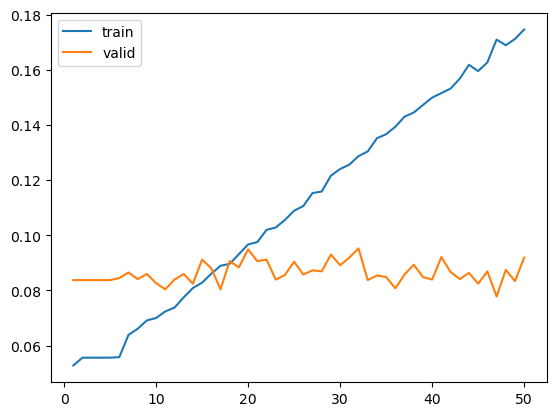

In [101]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 4.2 - Pruebas del Alumno

Pruebo cambiando el largo de la secuencia

In [102]:
# Largo de la secuencia, incluye seq input + word output
train_len = 11

# Código para hacer el desfazaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 
sequences = tok.texts_to_sequences(text_sequences)

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)

# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int - 1, num_classes=vocab_size)

# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 

# Largo del vector de salida --> vocab_size
output_size = vocab_size

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist2 = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

(26913, 10)
(26913,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 5)             13345     
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2668)              88044     
Total params: 154,413
Trainable params: 154,413
Non-trainable params: 0
___________________________

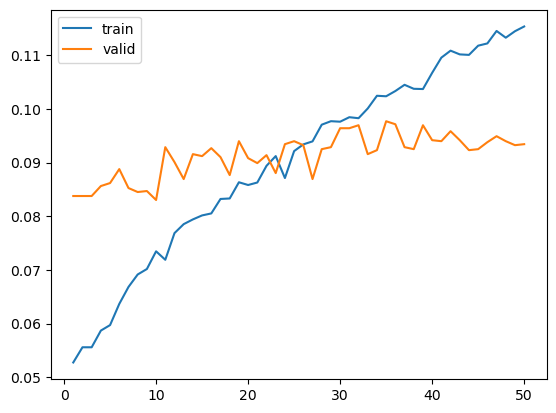

In [103]:
# Entrenamiento
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

Variar la longitud de la secuencia ha enlentencido el proceso de entrenamiento pero los accuracy de train y validation se acercaron.

Pruebo con una arquitectura mas grande:

In [105]:
# Largo de la secuencia, incluye seq input + word output
train_len = 11

# Código para hacer el desfazaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 
sequences = tok.texts_to_sequences(text_sequences)

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)

# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int - 1, num_classes=vocab_size)

# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 

# Largo del vector de salida --> vocab_size
output_size = vocab_size

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256)) # La última capa LSTM no lleva return_sequences
#model.add(Dense(256, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist3 = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

(26913, 10)
(26913,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 5)             13345     
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 256)           268288    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_8 (Dense)              (None, 2668)              685676    
Total params: 1,492,621
Trainable params: 1,492,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
673/673 [==============================] - 21s 26ms/step - loss: 6.2582 - accu

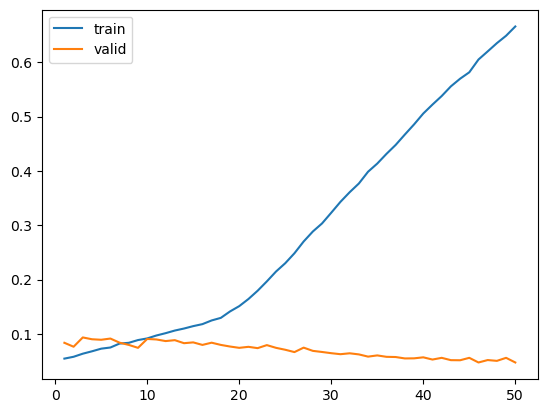

In [106]:
# Entrenamiento
epoch_count = range(1, len(hist3.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist3.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist3.history['val_accuracy'], label='valid')
plt.show()

Una arquitectura mas grande empeoró el overfitting.

Pruebo con una arquitectura mas chica sin la segunda capa densa

In [107]:
# Largo de la secuencia, incluye seq input + word output
train_len = 4

# Código para hacer el desfazaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 
sequences = tok.texts_to_sequences(text_sequences)

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)

# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int - 1, num_classes=vocab_size)

# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 

# Largo del vector de salida --> vocab_size
output_size = vocab_size

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32)) # La última capa LSTM no lleva return_sequences
#model.add(Dense(16, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist4 = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

(26920, 3)
(26920,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 3, 5)              13345     
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4864      
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 32)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 2668)              88044     
Total params: 114,573
Trainable params: 114,573
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
673/673 [==============================] - 11s 11ms/step - loss: 6.3742 - accuracy:

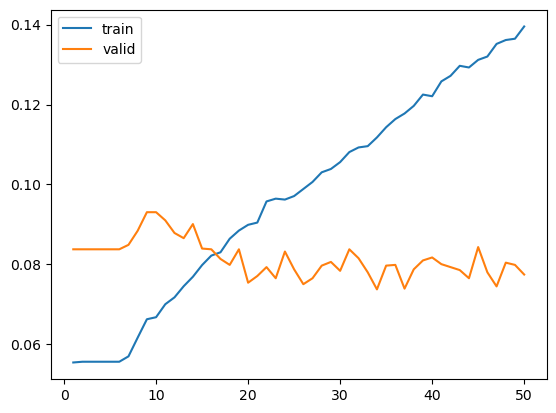

In [108]:
# Entrenamiento
epoch_count = range(1, len(hist4.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist4.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist4.history['val_accuracy'], label='valid')
plt.show()

Con una arquitectura mas chica sigue habiendo overfitting

Pruebo con una mas chica pero con la capa densa

In [109]:
# Largo de la secuencia, incluye seq input + word output
train_len = 4

# Código para hacer el desfazaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 
sequences = tok.texts_to_sequences(text_sequences)

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)

# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int - 1, num_classes=vocab_size)

# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 

# Largo del vector de salida --> vocab_size
output_size = vocab_size

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist5 = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

(26920, 3)
(26920,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 3, 5)              13345     
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 32)             4864      
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 32)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 2668)              88044     
Total params: 115,629
Trainable params: 115,629
Non-trainable params: 0
____________________________

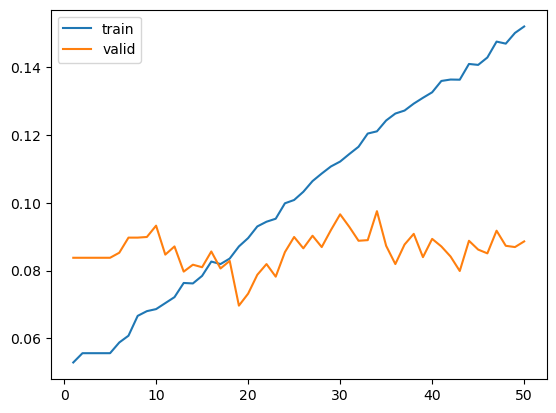

In [110]:
# Entrenamiento
epoch_count = range(1, len(hist5.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist5.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist5.history['val_accuracy'], label='valid')
plt.show()

Los resultados son similares al experimento anterior

Pruebo BRNN

In [120]:
# Largo de la secuencia, incluye seq input + word output
train_len = 4

# Código para hacer el desfazaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 
sequences = tok.texts_to_sequences(text_sequences)

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)

# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int - 1, num_classes=vocab_size)

# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 

# Largo del vector de salida --> vocab_size
output_size = vocab_size

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, activation='relu')))
model.add(Dense(32))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist6 = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

(26920, 3)
(26920,)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 3, 5)              13345     
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 128)            35840     
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_13 (Dense)             (None, 2668)              88044     
Total params: 240,173
Trainable params: 240,173
Non-trainable params: 0
____________________________

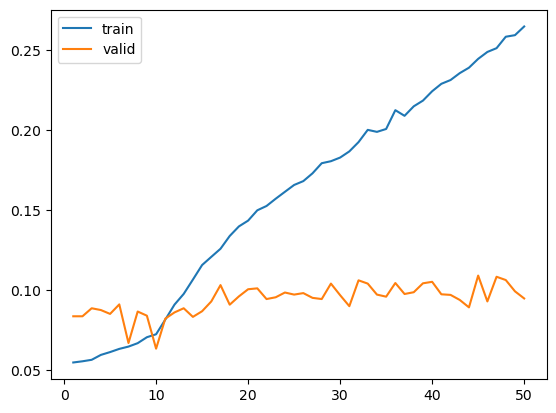

In [121]:
# Entrenamiento
epoch_count = range(1, len(hist6.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist6.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist6.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [112]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [111]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
#import sys
#!{sys.executable} -m pip install gradio --quiet

In [114]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra que corresponde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    print(f"Human text: {human_text} . Response: {out_word}")
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Human text: alice entered to the . Response: that's
Human text: alice entered to . Response: must
Human text: she was now  . Response: and
Human text: the rabbit said  . Response: 
Human text: the rabbit said how  . Response: still
Human text: what a curious  . Response: my
Human text: pour the waters  . Response: it
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x1d7132dcc40>, 'http://127.0.0.1:7860/', None)

### 6 - Generación de secuencias nuevas

In [115]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [118]:
input_text="Perhaps it doesn\'t understand"

generate_seq(model, tok, input_text, max_length=3, n_words=5)

"Perhaps it doesn't understand and you them in "

### 7 - Conclusiones
El modelo entrenado tuvo un muy mal desempeño en el entrenamiento además de overfitting en validation.
- Agrandar la arquitectura de la red no mejoró el resultado
- Achicar la arquitectura no redujo el overfitting
- Si bien utilizando BRNN mejoró los resultados de Train y Validation, también se sigue observando overfitting


El ratio de cantidad de documentos sobre cantidad de tokens es muy pequeño por lo que estos resultados eran esperables.